In [1]:
from datasetsforecast.long_horizon2 import LongHorizon2, ETTh1
import pandas as pd

In [2]:
Y_df = LongHorizon2.load(directory="data", group="ETTh1")
Y_df["ds"] = pd.to_datetime(Y_df["ds"])

n_time = len(Y_df.ds.unique())
val_size = int(0.2 * n_time)
test_size = int(0.2 * n_time)

Y_df

,index,ds,unique_id,y
0,0,2016-07-01 00:00:00,HUFL,-0.279827
1,1,2016-07-01 01:00:00,HUFL,-0.301290
2,2,2016-07-01 02:00:00,HUFL,-0.387142
3,3,2016-07-01 03:00:00,HUFL,-0.397873
4,4,2016-07-01 04:00:00,HUFL,-0.354948
...,...,...,...,...
100795,118915,2018-02-20 19:00:00,OT,-2.003877
100796,118916,2018-02-20 20:00:00,OT,-2.003877
100797,118917,2018-02-20 21:00:00,OT,-1.776565
100798,118918,2018-02-20 22:00:00,OT,-1.742809


In [3]:
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoInformer
from neuralforecast.losses.pytorch import MSE

In [ ]:
import torch
from optuna import Trial

torch.set_float32_matmul_precision("high")

horizon = ETTh1.horizons[0]


def get_config(trial: Trial):
    config = {
        "input_size": trial.suggest_categorical("input_size", [horizon]),
        "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
        "n_head": trial.suggest_categorical("n_head", [4, 8, 16]),
        "dropout": trial.suggest_categorical("dropout", [0, 0.05, 0.1, 0.2, 0.5]),
        "conv_hidden_size": trial.suggest_categorical(
            "conv_hidden_size", [16, 32, 64, 128]
        ),
        "distil": trial.suggest_categorical("distil", [True, False]),
        "activation": trial.suggest_categorical("activation", ["relu", "gelu"]),
        "encoder_layers": trial.suggest_categorical("encoder_layers", [2, 3, 4, 6]),
        "decoder_layers": trial.suggest_categorical("decoder_layers", [2]),
        "learning_rate": trial.suggest_categorical("learning_rate", [1e-4]),
        "scaler_type": trial.suggest_categorical("scaler_type", ["robust"]),
        "max_steps": trial.suggest_categorical("max_steps", [8]),
        "batch_size": trial.suggest_categorical("batch_size", [32]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [1024]),
        "random_seed": trial.suggest_categorical("random_seed", [1]),
    }
    return config


models = [
    AutoInformer(
        h=horizon, loss=MSE(), num_samples=25, config=get_config, backend="optuna"
    ),
]
nf = NeuralForecast(models=models, freq=ETTh1.freq.lower())
Y_hat_df = nf.cross_validation(
    df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
)

/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
[I 2025-11-16 11:21:23,639] A new study created in memory with name: no-name-92254409-ea1f-44bc-aed6-97f17e47d8fa
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_ste

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:21:38,329] Trial 0 finished with value: 0.9571017622947693 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 8, 'dropout': 0.05, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.9571017622947693.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:21:55,939] Trial 1 finished with value: 0.9734259843826294 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 8, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': False, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.9571017622947693.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:06,041] Trial 2 finished with value: 0.995055615901947 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 128, 'distil': False, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.9571017622947693.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:11,994] Trial 3 finished with value: 1.1386114358901978 and parameters: {'input_size': 96, 'hidden_size': 64, 'n_head': 16, 'dropout': 0.05, 'conv_hidden_size': 16, 'distil': False, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.9571017622947693.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:18,920] Trial 4 finished with value: 1.0011787414550781 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 4, 'dropout': 0.1, 'conv_hidden_size': 128, 'distil': False, 'activation': 'relu', 'encoder_layers': 2, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.9571017622947693.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:26,918] Trial 5 finished with value: 0.8449630737304688 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:H

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:32,166] Trial 6 finished with value: 1.0158451795578003 and parameters: {'input_size': 96, 'hidden_size': 128, 'n_head': 16, 'dropout': 0.1, 'conv_hidden_size': 128, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:35,385] Trial 7 finished with value: 1.069921612739563 and parameters: {'input_size': 96, 'hidden_size': 64, 'n_head': 8, 'dropout': 0.5, 'conv_hidden_size': 128, 'distil': True, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:H

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:52,352] Trial 8 finished with value: 0.9918811321258545 and parameters: {'input_size': 96, 'hidden_size': 512, 'n_head': 4, 'dropout': 0, 'conv_hidden_size': 16, 'distil': False, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:H

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:22:54,877] Trial 9 finished with value: 1.0454131364822388 and parameters: {'input_size': 96, 'hidden_size': 64, 'n_head': 4, 'dropout': 0.5, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 2, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:02,886] Trial 10 finished with value: 0.8644341826438904 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:10,907] Trial 11 finished with value: 0.8645326495170593 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:18,922] Trial 12 finished with value: 0.8644765615463257 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:26,947] Trial 13 finished with value: 0.8646019101142883 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:32,202] Trial 14 finished with value: 0.9632571935653687 and parameters: {'input_size': 96, 'hidden_size': 128, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:40,068] Trial 15 finished with value: 0.8449907898902893 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:47,977] Trial 16 finished with value: 0.8451030850410461 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 5 with value: 0.8449630737304688.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:23:55,903] Trial 17 finished with value: 0.84492027759552 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 17 with value: 0.84492027759552.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:00,031] Trial 18 finished with value: 0.997717559337616 and parameters: {'input_size': 96, 'hidden_size': 128, 'n_head': 8, 'dropout': 0, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 17 with value: 0.84492027759552.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:06,313] Trial 19 finished with value: 0.9739909172058105 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 4, 'dropout': 0, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 17 with value: 0.84492027759552.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HP

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:14,221] Trial 20 finished with value: 0.8452085852622986 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 17 with value: 0.84492027759552.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:H

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:22,116] Trial 21 finished with value: 0.8447450399398804 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 21 with value: 0.8447450399398804.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:30,033] Trial 22 finished with value: 0.8450921177864075 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 21 with value: 0.8447450399398804.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:37,942] Trial 23 finished with value: 0.8450206518173218 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 21 with value: 0.8447450399398804.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
[I 2025-11-16 11:24:45,938] Trial 24 finished with value: 0.9289386868476868 and parameters: {'input_size': 96, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.5, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 21 with value: 0.8447450399398804.
INFO:lightning_fabric.utilities.seed:Seed set to 1
/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/neuralforecast/common/_base_model.py:591: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_ze

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=8` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
nf.models[0].results.best_params

{'input_size': 96,
 'hidden_size': 256,
 'n_head': 16,
 'dropout': 0,
 'conv_hidden_size': 16,
 'distil': True,
 'activation': 'gelu',
 'encoder_layers': 6,
 'decoder_layers': 2,
 'learning_rate': 0.0001,
 'scaler_type': 'robust',
 'max_steps': 8,
 'batch_size': 32,
 'windows_batch_size': 1024,
 'random_seed': 1}

In [6]:
Y_hat_df

,unique_id,ds,cutoff,AutoInformer,y
0,HUFL,2017-10-24 00:00:00,2017-10-23 23:00:00,-0.394131,0.385361
1,HUFL,2017-10-24 01:00:00,2017-10-23 23:00:00,-0.476158,0.117235
2,HUFL,2017-10-24 02:00:00,2017-10-23 23:00:00,-0.500838,0.192195
3,HUFL,2017-10-24 03:00:00,2017-10-23 23:00:00,-0.593302,0.085041
4,HUFL,2017-10-24 04:00:00,2017-10-23 23:00:00,-0.517107,0.138538
...,...,...,...,...,...
1871515,OT,2018-02-20 19:00:00,2018-02-16 23:00:00,-1.380273,-2.003877
1871516,OT,2018-02-20 20:00:00,2018-02-16 23:00:00,-1.426283,-2.003877
1871517,OT,2018-02-20 21:00:00,2018-02-16 23:00:00,-1.396687,-1.776565
1871518,OT,2018-02-20 22:00:00,2018-02-16 23:00:00,-1.526479,-1.742809


/tmp/ipykernel_16753/2381271557.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


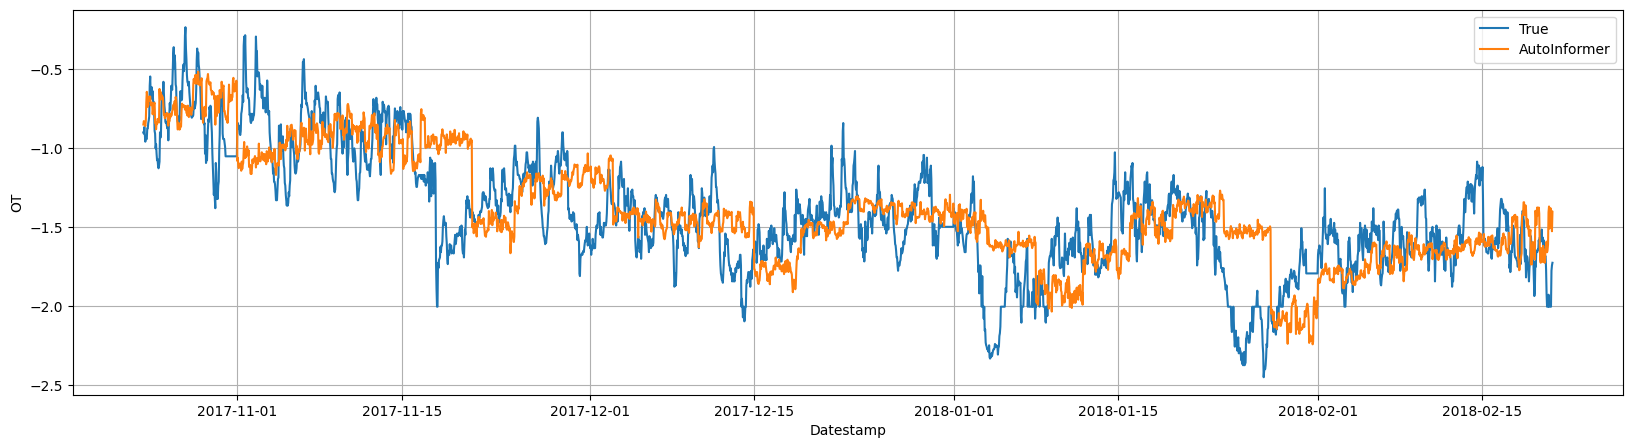

In [ ]:
import matplotlib.pyplot as plt

Y_plot = Y_hat_df[Y_hat_df["unique_id"] == "OT"]  # OT dataset
cutoffs = Y_hat_df["cutoff"].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]

plt.figure(figsize=(20, 5))
plt.plot(Y_plot["ds"], Y_plot["y"], label="True")
plt.plot(Y_plot["ds"], Y_plot["AutoInformer"], label="AutoInformer")
plt.xlabel("Datestamp")
plt.ylabel("OT")
plt.grid()
plt.legend();

In [ ]:
from neuralforecast.losses.numpy import mse

mse_informer = mse(Y_hat_df["y"], Y_hat_df["AutoInformer"])

print(f"Informer: {mse_informer:.3f}")

Informer: 0.545
